# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

### Download and unzip dataset

In [1]:
# can comment out after executing
#!wget "https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip"

In [2]:
# can comment out after executing
#!unzip processed_celeba_small.zip

There is a folder with additional images. I move the images in it to the upper directory and remove the old folder; you can do it in the notebook with the magic command `%%sh`, but I prefer to do it directly in the Terminal:

```bash
# cd into folder
cd processed_celeba_small/celeba/New\ Folder\ With Items
# mv alone doesn't work because of the argument length
find . -name '*.jpg' -exec mv {} ../ \;
# rm the old empty directory
cd ..
rm -f New\ Folder\ With\ Items
```

In [3]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/0.4.0/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [4]:
# necessary imports
import os
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [5]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # Implement function and return a dataloader
  
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + data_dir
    #subfolder = 'celeba'
    #train_path = os.path.join(image_path, subfolder)
    train_path = image_path

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    return train_loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [6]:
# Define function hyperparameters
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should see square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

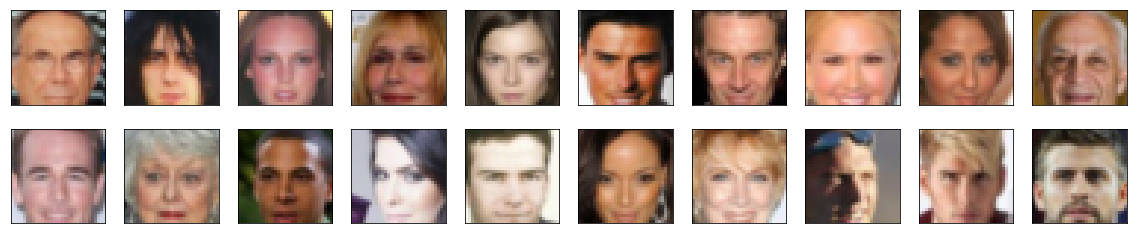

In [7]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [8]:
# Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_, max_ = feature_range
    x = x * (max_ - min_) + min_

    return x

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9608)
Max:  tensor(0.8196)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    # Note that the bias term is switched off: Wx+b -> Wx;
    # that is so because the batch normalization cancels it
    # when subtracting the mean (i.e., the bias would be already in the mean)
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [12]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim
        # Default values for all conv layers
        # so that the size of the image halvens
        # without pooling
        self.stride = 2
        self.kernel = 4
        self.padding = 1
        # Default image size, width = height
        self.size = 32
        self.in_channels = 3
        self.hidden_size = 256
        self.drop_p = 0.1
        
        # W_out = (W_in + 2P - F)/S + 1
        # W_out = (32 + 2 - 4)/2 + 1 = 16
        # Strided-Conv + LReLU
        self.conv1 = conv(in_channels=self.in_channels, # 3
                          out_channels=conv_dim, # 32
                          kernel_size=self.kernel,
                          stride=self.stride,
                          padding=self.padding,
                          batch_norm=False)

        # W_out = (W_in + 2P - F)/S + 1
        # W_out = (16 + 2 - 4)/2 + 1 = 8
        # Strided-Conv + BN + LReLU
        self.conv2 = conv(in_channels=conv_dim, # 32
                          out_channels=conv_dim*2, # 64
                          kernel_size=self.kernel,
                          stride=self.stride,
                          padding=self.padding,
                          batch_norm=True)

        # W_out = (W_in + 2P - F)/S + 1
        # W_out = (8 + 2 - 4)/2 + 1 = 4
        # Strided-Conv + BN + LReLU
        self.conv3 = conv(in_channels=conv_dim*2, # 64
                          out_channels=conv_dim*4, # 128
                          kernel_size=self.kernel,
                          stride=self.stride,
                          padding=self.padding,
                          batch_norm=True)
        
        # W_out = (W_in + 2P - F)/S + 1
        # W_out = (4 + 2 - 4)/2 + 1 = 2
        # Strided-Conv + BN + LReLU
        self.conv4 = conv(in_channels=conv_dim*4, # 128
                          out_channels=conv_dim*8, # 256
                          kernel_size=self.kernel,
                          stride=self.stride,
                          padding=self.padding,
                          batch_norm=True)
        
        # 2 x 2 x conv_dim*8
        W_out = int(self.size / self.stride**4) # 32/16 = 2
        # 2 x 2 x 256 = 1024
        self.fc1 = nn.Linear(W_out * W_out * conv_dim*(2**3), self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, 1)

        # dropout layer
        # good practice to add in-between linear layers
        self.dropout = nn.Dropout(self.drop_p)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        x = F.leaky_relu(self.conv1(x), 0.2) # (input, negative_slope=0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)

        # Flatten
        # x: (batch_size, channels, width, height)
        # x_in: (batch_size, channels*width*height)
        x = x.view(x.size(0), -1)
        
        # First linear layer + dropout
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        
        # Final classification linear layer
        # No activation = logits
        # We apply Softmax in the loss function: BCEWithLogitsLoss
        x = self.fc2(x)
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


#### Test Forward Pass: Discriminator

In [13]:
# Define discriminator
conv_dim = 32
D = Discriminator(conv_dim)

# Get image
dataiter = iter(celeba_train_loader)
images, labels = dataiter.next()
# scale
scaled_images = scale(images)
print(f"Input image size: {scaled_images.size()}")

# Discriminator pass
p = D(scaled_images)
print(f"Discriminator output size: {p.size()}")
# Discriminator output size:  torch.Size([32, 1])

Input image size: torch.Size([128, 3, 32, 32])
Discriminator output size: torch.Size([128, 1])


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [14]:
# helper deconv function
def t_conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    layers = []
    # Note that the bias term is switched off: Wx+b -> Wx;
    # that is so because the batch normalization cancels it
    # when subtracting the mean (i.e., the bias would be already in the mean)
    t_conv_layer = nn.ConvTranspose2d(in_channels,
                                      out_channels,
                                      kernel_size,
                                      stride,
                                      padding,
                                      bias=False)
    
    # append conv layer
    layers.append(t_conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [15]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.out_channels = 3
        self.conv_dim = conv_dim
        self.z_size = z_size
        self.size_end = 32 # final image size, width = height
        self.size_start = int(self.size_end / (2**4)) # 2 # initial image size
        
        # (conv_dim*8) * size/16 * size/16 = 32*8 * 2 * 2 = 1024
        self.fc_out = self.conv_dim*8 * self.size_start * self.size_start
        self.fc = nn.Linear(z_size, self.fc_out)

        # W_out = (W_in-1)*S - 2P + (F-1) + 1
        # A kernel of 4x4 with stride=2 and padding=1
        # doubles the size:
        # W_out = (W_in-1)*2 - 2 + (4-1) + 1 = 2W_in -2 -2 +3 +1 = 2W_in
        # W_out = 2W_in
        # W_out = 4 = 2*2
        self.t_conv1 = t_conv(in_channels=self.conv_dim*8,
                              out_channels=self.conv_dim*4,
                              kernel_size=4,
                              stride=2,
                              padding=1,
                              batch_norm=True)

        # W_out = 2W_in
        # W_out = 8 = 4*2
        self.t_conv2 = t_conv(in_channels=self.conv_dim*4,
                              out_channels=self.conv_dim*2,
                              kernel_size=4,
                              stride=2,
                              padding=1,
                              batch_norm=True)

        # W_out = 2W_in
        # W_out = 16 = 8*2
        self.t_conv3 = t_conv(in_channels=self.conv_dim*2,
                              out_channels=self.conv_dim,
                              kernel_size=4,
                              stride=2,
                              padding=1,
                              batch_norm=True)

        # W_out = 2W_in
        # W_out = 32 = 16*2
        self.t_conv4 = t_conv(in_channels=self.conv_dim,
                              out_channels=self.out_channels,
                              kernel_size=4,
                              stride=2,
                              padding=1,
                              batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # x in: (batch_size, z_size)
        # x out: (batch_size, fc_out)
        x = self.fc(x)
        
        # (batch_size, 4*conv_dim=128, 4, 4)
        x = x.view(x.size(0), self.conv_dim*8, self.size_start, self.size_start)
        
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = torch.tanh(self.t_conv4(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


#### Test Forward Pass: Generator

In [16]:
# Instantiate Gneerator
z_size = 256
G = Generator(z_size=z_size, conv_dim=32)

# Generate noise vector
z = np.random.uniform(-1, 1, size=(batch_size, z_size))
z = torch.from_numpy(z).float()
print(f"Input noise vector size: {z.size()}")

x = G(z)
print(f"Generator output size: {x.size()}")
# Generator output size:  torch.Size([32, 3, 32, 32])

Input noise vector size: torch.Size([128, 256])
Generator output size: torch.Size([128, 3, 32, 32])


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [17]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    mean_value = 0.0
    std_value = 0.02
    # Apply initial weights to convolutional and linear layers
    # For every Linear layer in a model..
    if classname.find('Linear') != -1:
        m.weight.data.normal_(mean_value,std=std_value)
        m.bias.data.fill_(mean_value)    
    if classname.find('Conv2d') != -1:
        m.weight.data.normal_(mean_value,std=std_value)        

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [19]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 256

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.1)
)

Generator(
  (fc): Linear(in_features=256, out_features=1024, bias=True)
  (t_conv1): Sequential(
    (0

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [21]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [22]:
import torch.optim as optim

# Parameters: from DCGAN paper
lr = 0.0002
beta1 = 0.5
beta2 = 0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Saving Models

In [23]:
def checkpoint(epoch, G, D, checkpoint_dir='checkpoints_gan'):
    """Saves the parameters of both the generator G and the discriminator D.
    """
    G_path = os.path.join(checkpoint_dir, 'G.pt')
    D_path = os.path.join(checkpoint_dir, 'D.pt')
    torch.save(G.state_dict(), G_path)
    torch.save(D.state_dict(), D_path)

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [24]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size = 16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            #####
            # A) Train the discriminator on real and fake images
            #####

            d_optimizer.zero_grad()

            # 1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images
            # In this concrete case label smoothing is off
            # because we see experimentally that it works better so
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            #####
            # B) Train the generator with an adversarial loss
            #####
            
            g_optimizer.zero_grad()

            # 1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        with torch.no_grad():
            samples_z = G(fixed_z)
            samples_z = samples_z.detach().cpu()
            samples.append(samples_z)
        G.train() # back to training mode

        # Save model checkpoint
        checkpoint(epoch, G, D)
        
    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [25]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from workspace_utils import active_session

# call training function
with active_session():
    losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.3865 | g_loss: 0.7365
Epoch [    1/   50] | d_loss: 0.0614 | g_loss: 5.1297
Epoch [    1/   50] | d_loss: 0.3377 | g_loss: 3.2899
Epoch [    1/   50] | d_loss: 0.4778 | g_loss: 3.9160
Epoch [    1/   50] | d_loss: 0.3714 | g_loss: 2.3052
Epoch [    1/   50] | d_loss: 0.4796 | g_loss: 1.4615
Epoch [    1/   50] | d_loss: 0.5242 | g_loss: 2.3798
Epoch [    1/   50] | d_loss: 0.7819 | g_loss: 3.8050
Epoch [    1/   50] | d_loss: 1.0286 | g_loss: 3.7639
Epoch [    1/   50] | d_loss: 0.7176 | g_loss: 2.2817
Epoch [    1/   50] | d_loss: 0.6969 | g_loss: 1.8579
Epoch [    1/   50] | d_loss: 0.8739 | g_loss: 3.0619
Epoch [    1/   50] | d_loss: 0.8285 | g_loss: 1.4849
Epoch [    1/   50] | d_loss: 0.7862 | g_loss: 2.2019
Epoch [    1/   50] | d_loss: 0.8362 | g_loss: 1.8807
Epoch [    2/   50] | d_loss: 0.8319 | g_loss: 1.6534
Epoch [    2/   50] | d_loss: 0.7087 | g_loss: 2.4842
Epoch [    2/   50] | d_loss: 0.9554 | g_loss: 3.2499
Epoch [    2/   50] | d_loss

Epoch [   12/   50] | d_loss: 0.4662 | g_loss: 1.9979
Epoch [   12/   50] | d_loss: 0.8775 | g_loss: 5.2779
Epoch [   12/   50] | d_loss: 0.5038 | g_loss: 3.0712
Epoch [   12/   50] | d_loss: 0.6976 | g_loss: 3.0589
Epoch [   13/   50] | d_loss: 0.5999 | g_loss: 5.1459
Epoch [   14/   50] | d_loss: 0.9977 | g_loss: 6.4074
Epoch [   14/   50] | d_loss: 0.8911 | g_loss: 2.0312
Epoch [   14/   50] | d_loss: 0.4675 | g_loss: 3.5292
Epoch [   14/   50] | d_loss: 0.6156 | g_loss: 5.0692
Epoch [   14/   50] | d_loss: 0.4437 | g_loss: 3.3518
Epoch [   14/   50] | d_loss: 0.4983 | g_loss: 3.7051
Epoch [   14/   50] | d_loss: 0.1936 | g_loss: 3.4579
Epoch [   14/   50] | d_loss: 0.4683 | g_loss: 3.3023
Epoch [   14/   50] | d_loss: 0.2317 | g_loss: 3.9667
Epoch [   14/   50] | d_loss: 0.6038 | g_loss: 2.0805
Epoch [   14/   50] | d_loss: 0.3193 | g_loss: 3.1173
Epoch [   14/   50] | d_loss: 0.3321 | g_loss: 2.3363
Epoch [   14/   50] | d_loss: 0.2776 | g_loss: 2.1746
Epoch [   14/   50] | d_loss

Epoch [   24/   50] | d_loss: 0.3530 | g_loss: 5.5948
Epoch [   25/   50] | d_loss: 0.3177 | g_loss: 3.6320
Epoch [   25/   50] | d_loss: 0.4789 | g_loss: 3.8841
Epoch [   25/   50] | d_loss: 0.2462 | g_loss: 5.1771
Epoch [   25/   50] | d_loss: 0.1892 | g_loss: 3.3681
Epoch [   25/   50] | d_loss: 1.4277 | g_loss: 7.6243
Epoch [   25/   50] | d_loss: 0.1317 | g_loss: 4.7520
Epoch [   26/   50] | d_loss: 0.0740 | g_loss: 6.4511
Epoch [   26/   50] | d_loss: 0.2357 | g_loss: 4.4726
Epoch [   26/   50] | d_loss: 0.0810 | g_loss: 4.6742
Epoch [   26/   50] | d_loss: 0.2216 | g_loss: 4.1574
Epoch [   26/   50] | d_loss: 0.1837 | g_loss: 5.0233
Epoch [   26/   50] | d_loss: 0.2685 | g_loss: 6.7307
Epoch [   26/   50] | d_loss: 0.3792 | g_loss: 3.0131
Epoch [   26/   50] | d_loss: 0.2679 | g_loss: 1.7662
Epoch [   26/   50] | d_loss: 0.2737 | g_loss: 4.4172
Epoch [   26/   50] | d_loss: 0.6545 | g_loss: 3.7930
Epoch [   26/   50] | d_loss: 0.1487 | g_loss: 5.0797
Epoch [   26/   50] | d_loss

Epoch [   36/   50] | d_loss: 0.0743 | g_loss: 4.8035
Epoch [   36/   50] | d_loss: 0.4450 | g_loss: 7.8040
Epoch [   36/   50] | d_loss: 0.2275 | g_loss: 4.7920
Epoch [   36/   50] | d_loss: 0.2675 | g_loss: 2.5989
Epoch [   36/   50] | d_loss: 0.1510 | g_loss: 4.7144
Epoch [   36/   50] | d_loss: 0.8658 | g_loss: 3.2060
Epoch [   36/   50] | d_loss: 0.2579 | g_loss: 6.6866
Epoch [   37/   50] | d_loss: 0.0629 | g_loss: 4.6408
Epoch [   37/   50] | d_loss: 0.0981 | g_loss: 5.2238
Epoch [   37/   50] | d_loss: 0.1931 | g_loss: 3.9650
Epoch [   37/   50] | d_loss: 0.0569 | g_loss: 4.6905
Epoch [   37/   50] | d_loss: 0.2154 | g_loss: 5.1026
Epoch [   37/   50] | d_loss: 0.1272 | g_loss: 3.6070
Epoch [   37/   50] | d_loss: 0.0923 | g_loss: 5.7421
Epoch [   37/   50] | d_loss: 0.3242 | g_loss: 5.5194
Epoch [   37/   50] | d_loss: 0.1917 | g_loss: 4.1582
Epoch [   37/   50] | d_loss: 0.2816 | g_loss: 3.2711
Epoch [   37/   50] | d_loss: 0.4423 | g_loss: 3.9067
Epoch [   37/   50] | d_loss

Epoch [   47/   50] | d_loss: 0.3602 | g_loss: 3.4094
Epoch [   47/   50] | d_loss: 1.6193 | g_loss: 9.4458
Epoch [   47/   50] | d_loss: 0.1788 | g_loss: 6.7157
Epoch [   47/   50] | d_loss: 0.1589 | g_loss: 7.0015
Epoch [   47/   50] | d_loss: 0.0509 | g_loss: 5.0717
Epoch [   47/   50] | d_loss: 0.0504 | g_loss: 6.8482
Epoch [   47/   50] | d_loss: 0.0366 | g_loss: 6.7766
Epoch [   47/   50] | d_loss: 0.1134 | g_loss: 5.7549
Epoch [   47/   50] | d_loss: 0.3846 | g_loss: 4.4567
Epoch [   48/   50] | d_loss: 0.0471 | g_loss: 4.5687
Epoch [   48/   50] | d_loss: 0.1125 | g_loss: 5.3096
Epoch [   48/   50] | d_loss: 0.3794 | g_loss: 4.6857
Epoch [   48/   50] | d_loss: 0.4193 | g_loss: 5.3019
Epoch [   48/   50] | d_loss: 0.1067 | g_loss: 7.2506
Epoch [   48/   50] | d_loss: 0.2729 | g_loss: 5.2916
Epoch [   48/   50] | d_loss: 0.4230 | g_loss: 4.8623
Epoch [   48/   50] | d_loss: 0.2203 | g_loss: 4.5484
Epoch [   48/   50] | d_loss: 0.5453 | g_loss: 4.2168
Epoch [   48/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

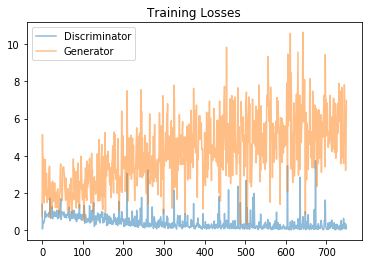

In [26]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [27]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [28]:
# Number of fixed sample sets
len(samples)

50

In [29]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

Last epoch:


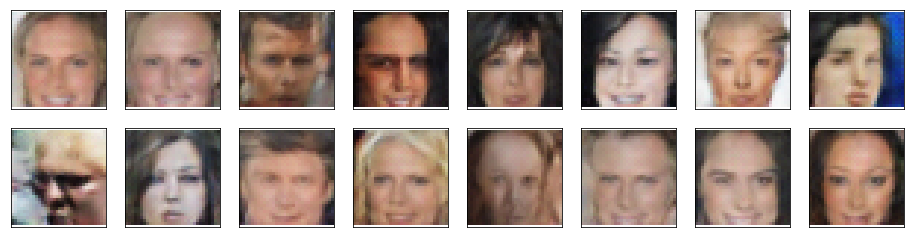

In [38]:
print('Last epoch:')
_ = view_samples(-1, samples)

Epoch: 45


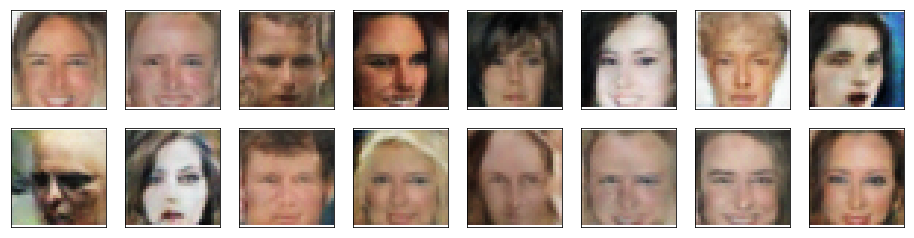

In [39]:
e = 45
print(f'Epoch: {e}')
_ = view_samples(e-1, samples)

Epoch: 40


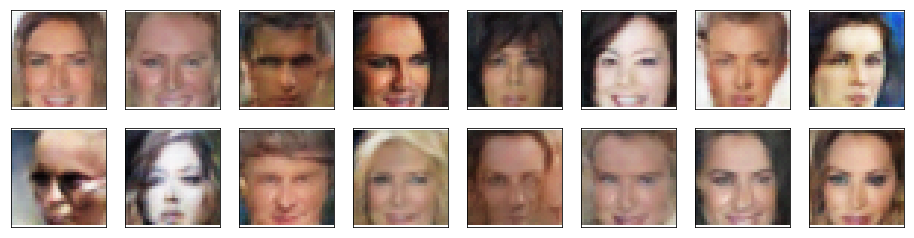

In [40]:
e = 40
print(f'Epoch: {e}')
_ = view_samples(e-1, samples)

Epoch: 30


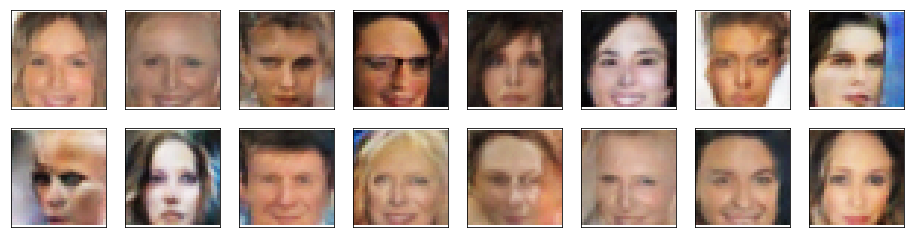

In [41]:
e = 30
print(f'Epoch: {e}')
_ = view_samples(e-1, samples)

Epoch: 20


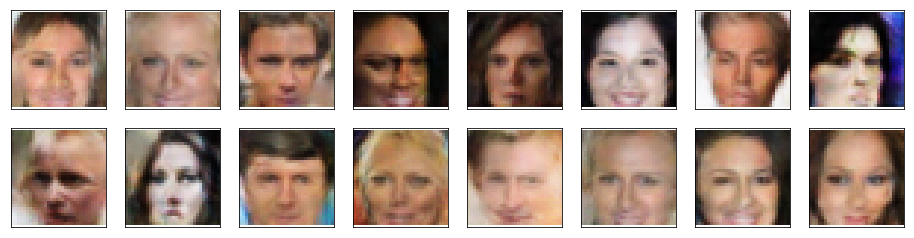

In [42]:
e = 20
print(f'Epoch: {e}')
_ = view_samples(e-1, samples)

Epoch: 10


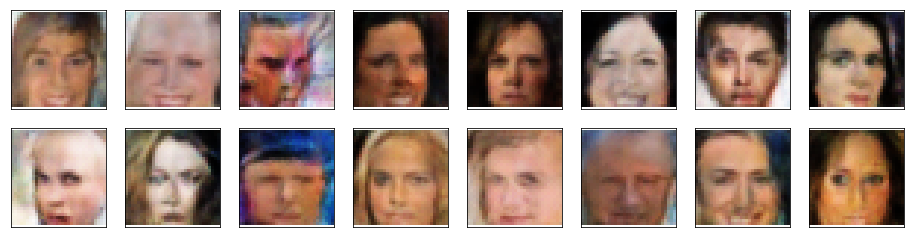

In [43]:
e = 10
print(f'Epoch: {e}')
_ = view_samples(e-1, samples)

Epoch: 5


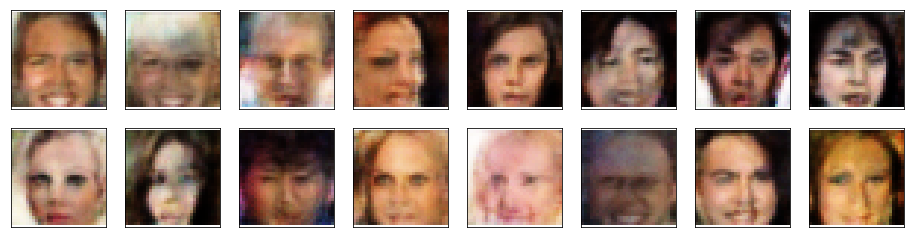

In [44]:
e = 5
print(f'Epoch: {e}')
_ = view_samples(e-1, samples)

Epoch: 1


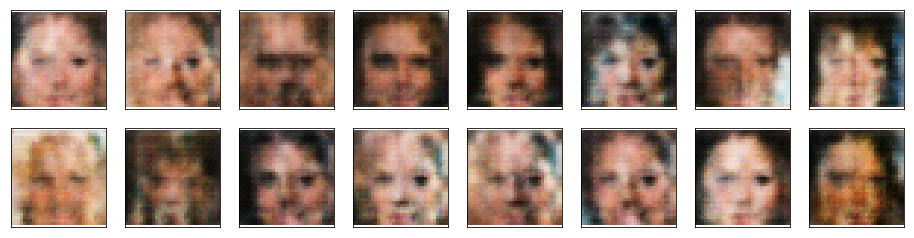

In [45]:
e = 1
print(f'Epoch: {e}')
_ = view_samples(e-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.